#### COMP 215 - Project 01

# Plotting Potentially Hazardous Near Earth Objects

#### Name: Ben Blair
#### Date: 27/02/2023

## Project Description
This application allows the user to plot the close-approach record for the near earth objects in a given date range.

Note: All data is pulled from NASA's Near Earth Object Web Service (NeoWs).

## Instructions

1.   Start by running the 'Import' code block below.
2.   Set your parameters and run the code block.
3.   Run all remaining code blocks.
4.   Scroll all the way to the bottom to view the display.



## Import

In [110]:
# Import the necessary modules
import datetime, json, requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint

# Set the API key
API_KEY = 'GT5a6VBQVVTnT8H1jSPfja2DfDMaC1d0UsYeWsYW'

## Set the Parameters

`search_start`: Start date for the search period.
> *Valid inputs: any date of the form YYYY-MM-DD between 1900 and 2200*

`search_end`: End date for the search period.
> *Valid inputs: any date of the form YYYY-MM-DD between 1900 and 2200*

`disp_start`: Start date for the display period.
> *Valid inputs: any date of the form YYYY-MM-DD between 1900 and 2200*

`disp_end`: End date for the display period.
> *Valid inputs: any date of the form YYYY-MM-DD between 1900 and 2200*

`orbiting_body`: The celestial body around which the neo orbits.
> *Valid inputs: Earth, Moon, Venus*

`only_hazardous`: `True` displays only NEOs identified as potentially hazardous while `False` displays all NEOs.
> *Valid inputs:* `True` *or* `False`

In [111]:
# Define the parameters
search_start = '2023-02-14'
search_end = '2023-02-14'

disp_start = '1900-01-01'
disp_end = '2200-01-01'

orbiting_body = 'Earth'

only_hazardous = True

## Query the NASA Database

In [112]:
url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={search_start}&end_date={search_end}&api_key={API_KEY}'
response = requests.request("GET", url, headers={}, data={})
data = json.loads(response.text)

In [113]:
neo_count = data['element_count']
neos = [neo for day in data['near_earth_objects'] for neo in data['near_earth_objects'][day]]

print(f'{neo_count} near earth objects detected for the period {search_start} to {search_end}.')

pprint(neos)  # TODO: Delete this line when finished

22 near earth objects detected for the period 2023-02-14 to 2023-02-14.
[{'absolute_magnitude_h': 19.82,
  'close_approach_data': [{'close_approach_date': '2023-02-14',
                           'close_approach_date_full': '2023-Feb-14 22:37',
                           'epoch_date_close_approach': 1676414220000,
                           'miss_distance': {'astronomical': '0.4795985639',
                                             'kilometers': '71746923.614498893',
                                             'lunar': '186.5638413571',
                                             'miles': '44581471.0637670034'},
                           'orbiting_body': 'Earth',
                           'relative_velocity': {'kilometers_per_hour': '104275.3251108074',
                                                 'kilometers_per_second': '28.9653680863',
                                                 'miles_per_hour': '64792.6318723237'}}],
  'estimated_diameter': {'feet': {'estimated_diam

## Get Only Hazardous NEOs

In [114]:
if only_hazardous == True:
    neo_ids = [neo['id'] for neo in neos if neo['is_potentially_hazardous_asteroid'] == True]
else:
    neo_ids = [neo['id'] for neo in neos]

pprint(neo_ids)  # TODO: Delete this line when finished

['2419880', '3840136', '54316644']


## Fetch Orbital Data for Each NEO

In [115]:
def get_neo_data(id):
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}/?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    
    approach_dates = [datetime.date.fromisoformat(approach['close_approach_date']) for approach in data['close_approach_data'] if approach['orbiting_body'] == orbiting_body]
    miss_distances = [float(approach['miss_distance']['kilometers']) for approach in data['close_approach_data'] if approach['orbiting_body'] == orbiting_body]
    orbital_period = data['orbital_data']['orbital_period']

    neo_data = {'approach_dates': approach_dates,
                'miss_distances': miss_distances,
                'orbital_period': orbital_period}
    
    return neo_data

In [116]:
neo_datasets = {id:get_neo_data(id) for id in neo_ids}
pprint(neo_datasets)

{'2419880': {'approach_dates': [datetime.date(1907, 2, 12),
                                datetime.date(1910, 11, 23),
                                datetime.date(1914, 9, 8),
                                datetime.date(2006, 9, 2),
                                datetime.date(2010, 9, 24),
                                datetime.date(2014, 12, 1),
                                datetime.date(2019, 1, 23),
                                datetime.date(2023, 2, 14),
                                datetime.date(2127, 2, 21),
                                datetime.date(2130, 12, 5),
                                datetime.date(2134, 9, 7),
                                datetime.date(2158, 2, 16),
                                datetime.date(2161, 10, 27),
                                datetime.date(2185, 1, 21),
                                datetime.date(2188, 9, 9)],
             'miss_distances': [30682925.241114773,
                                42840783.48025458

## Plot the NEO Data

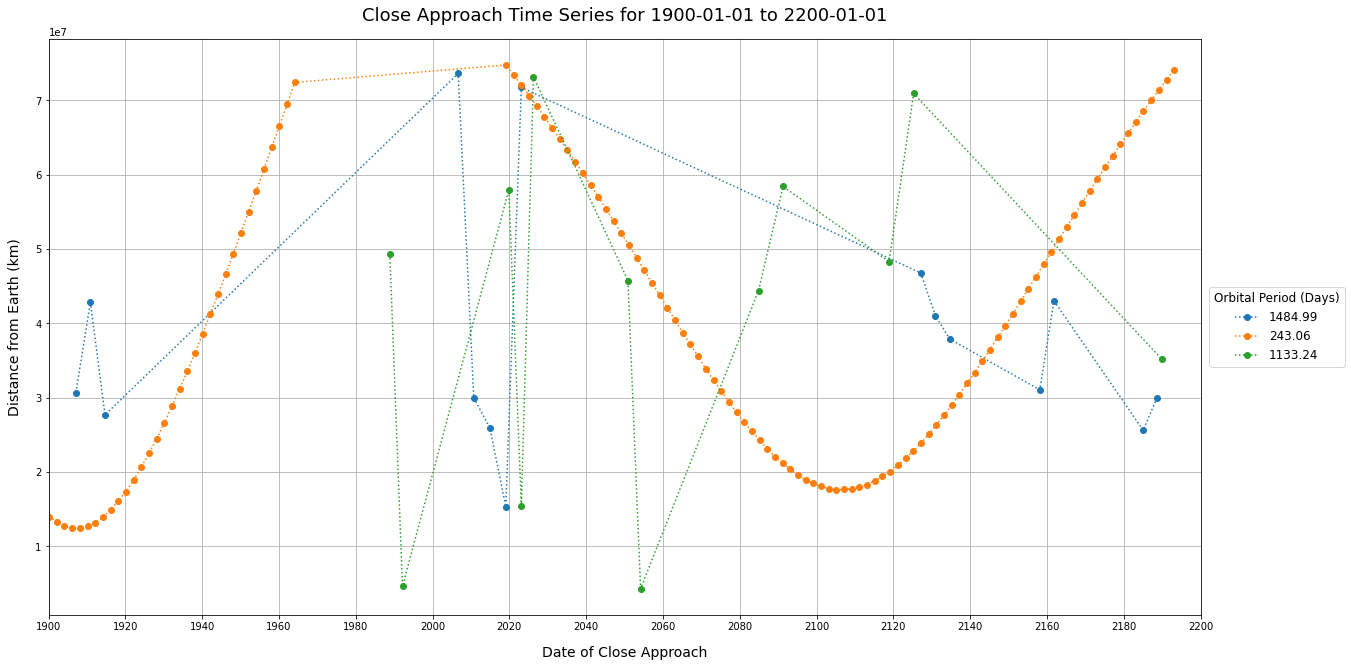

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(16,8), layout='constrained')
axs[0].set_position([0,1,1,1])
axs[1].set_position([1,1,0,0])
axs[1].set(visible=False)

axs[0].set_title(f'Close Approach Time Series for {disp_start} to {disp_end}', fontsize=18, pad=18)

axs[0].set_xlabel('Date of Close Approach', labelpad=14, fontsize=14)
axs[0].set_ylabel(f'Distance from {orbiting_body} (km)', labelpad=14, fontsize=14)

# Borrowed from Matplotlib's guide
locator = mdates.AutoDateLocator(maxticks=25)
formatter = mdates.ConciseDateFormatter(locator)
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].set_xlim(left=datetime.date.fromisoformat(disp_start), right=datetime.date.fromisoformat(disp_end))

axs[0].grid(visible=True, which='both')

for id in neo_datasets:
    x = neo_datasets[id]['approach_dates']
    y = neo_datasets[id]['miss_distances']
    orbital_period = float(neo_datasets[id]['orbital_period'])
    axs[0].plot(x, y, 'o', linestyle=':', label=f'{orbital_period:.2f}')

axs[0].legend(title='Orbital Period (Days)', loc='center right', borderaxespad=-12, title_fontsize=12, fontsize=12)

plt.show()